# Outliers detection

How to deal with outliers?

* If it is obvious that the outlier is due to incorrectly entered or measured data, you should drop the outlier.

* If the outlier does not change the results but does affect assumptions, you may drop the outlier.

* More commonly, the outlier affects both results and assumptions. In this situation, it is not legitimate to simply drop the outlier. You may run the analysis both with and without it, but you should state in at least a footnote the dropping of any such data points and how the results changed.

* If the outlier creates a significant association, you should drop the outlier and should not report any significance from your analysis.

# Unsupervised learning methods for outliers detection 

## Isolation Forest

The IsolationForest "isolates" observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.
Random partitioning produces noticeable shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

![Isolation Forest](images/isolation_forest.png)
Image source: https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561

## Local Outlier Factor

The local outlier factor (LOF) method scores points in a multivariate dataset whose rows are assumed to be generated independently from the same probability distribution.

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.

![Local Outlier Factor](images/lof.jpeg)
Image source: http://www.cse.ust.hk/~leichen/courses/comp5331/lectures/LOF_Example.pdf

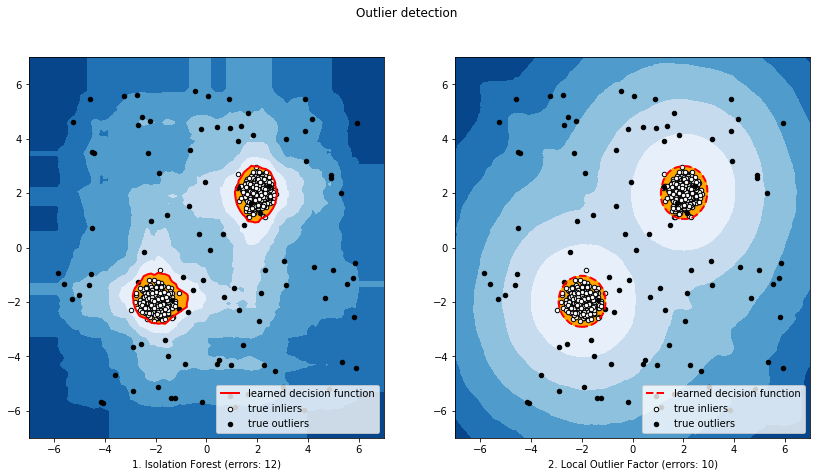

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np

from scipy import stats
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


rng = np.random.RandomState(42)

n_samples = 1000
outliers_fraction = 0.10

# define two outlier detection tools to be compared
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=n_samples, contamination=outliers_fraction, random_state=rng),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=175, contamination=outliers_fraction)
}

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

np.random.seed(42)
# Data generation
X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - 2
X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + 2
X = np.r_[X1, X2]
# Add outliers
X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

# Fit the model
plt.figure(figsize=(14, 7))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
        Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

    threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)
    n_errors = (y_pred != ground_truth).sum()
    Z = Z.reshape(xx.shape)
    subplot = plt.subplot(1, 2, i + 1)
    subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r)
    a = subplot.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')
    b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white', s=20, edgecolor='k')
    c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black', s=20, edgecolor='k')
    subplot.axis('tight')
    subplot.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'true inliers', 'true outliers'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='lower right'
    )
    subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
    subplot.set_xlim((-7, 7))
    subplot.set_ylim((-7, 7))
plt.suptitle("Outlier detection")
plt.show()

### References
1. https://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/
2. Fei Tony Liu, Kai Ming Ting, and Zhi-Hua Zhou. 2008. Isolation Forest. In Proceedings of the 2008 Eighth IEEE International Conference on Data Mining (ICDM '08). IEEE Computer Society, Washington, DC, USA, 413-422.
3. Markus M. Breunig, Hans-Peter Kriegel, Raymond T. Ng, and Jörg Sander. 2000. LOF: identifying density-based local outliers. SIGMOD Rec. 29, 2 (May 2000), 93-104.